In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
import pandas as pd
import xgboost
from prophet import Prophet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,root_mean_squared_error
)
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX

from src.functions.arima_parameters import arima_parameters, seasonal_order
from src.utils import init_notebook

In [3]:
init_notebook()

## Prophet

### Pré-traitement pour Prophet

In [34]:
# relecture des données (sans detrend)
data_folder = "data/raw_data"
stock_name = "AAPL"
df = pd.read_csv(
    f"{data_folder}/{stock_name}.csv", parse_dates=["Date"], index_col="Date"
)
print(f"{df.shape = }")

df.shape = (756, 6)


In [35]:
train_start_date = "2019"
train_end_date = "2021-10-01"
df_train = df.loc[train_start_date:train_end_date].copy()
df_test = df.loc[train_end_date:].copy()

In [36]:
df_train["time_dummy"] = range(len(df_train))
df_test["time_dummy"] = range(len(df_test))
df_test["time_dummy"] += len(df_train)
df_train["day"] = df_train.index.day
df_test["day"] = df_test.index.day

In [37]:
df_train.shape

(694, 8)

In [38]:
x = df_train[[]].copy()

In [39]:
x_col = ["time_dummy", "day"]
y_col = ["Close"]

In [40]:
x["ds"] = df_train.index
x["y"] = df_train[["Close"]]

In [41]:
df_test.head()

,Open,High,Low,Close,Adj Close,Volume,time_dummy,day
Date,,,,,,,,
2021-10-01,141.899994,142.919998,139.110001,142.649994,141.018539,94639600,694,1
2021-10-04,141.759995,142.210007,138.270004,139.139999,137.548676,98322000,695,4
2021-10-05,139.490005,142.240005,139.360001,141.110001,139.496140,80861100,696,5
2021-10-06,139.470001,142.149994,138.369995,142.000000,140.375946,83221100,697,6
2021-10-07,143.059998,144.220001,142.720001,143.289993,141.651215,61732700,698,7


In [42]:
x_test = df_test[x_col]
y_test = df_test[y_col]

In [43]:
x.head()

,ds,y
Date,,
2019-01-02,2019-01-02,39.480000
2019-01-03,2019-01-03,35.547501
2019-01-04,2019-01-04,37.064999
2019-01-07,2019-01-07,36.982498
2019-01-08,2019-01-08,37.687500


### Prédiction

#### Calcul de la prédiction

In [44]:
model = Prophet()
model.fit(x)

01:19:47 - cmdstanpy - INFO - Chain [1] start processing
01:19:47 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
future = x_test.copy()
future["ds"] = x_test.index

In [46]:
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
58,2021-12-23,164.084319,157.965905,170.341980
59,2021-12-27,165.483298,159.145845,171.705504
60,2021-12-28,165.809740,159.537970,172.142187
61,2021-12-29,166.157137,159.675974,172.614857
62,2021-12-30,166.183145,159.860610,172.941168


#### Affichage de la prédiction

C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\.venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


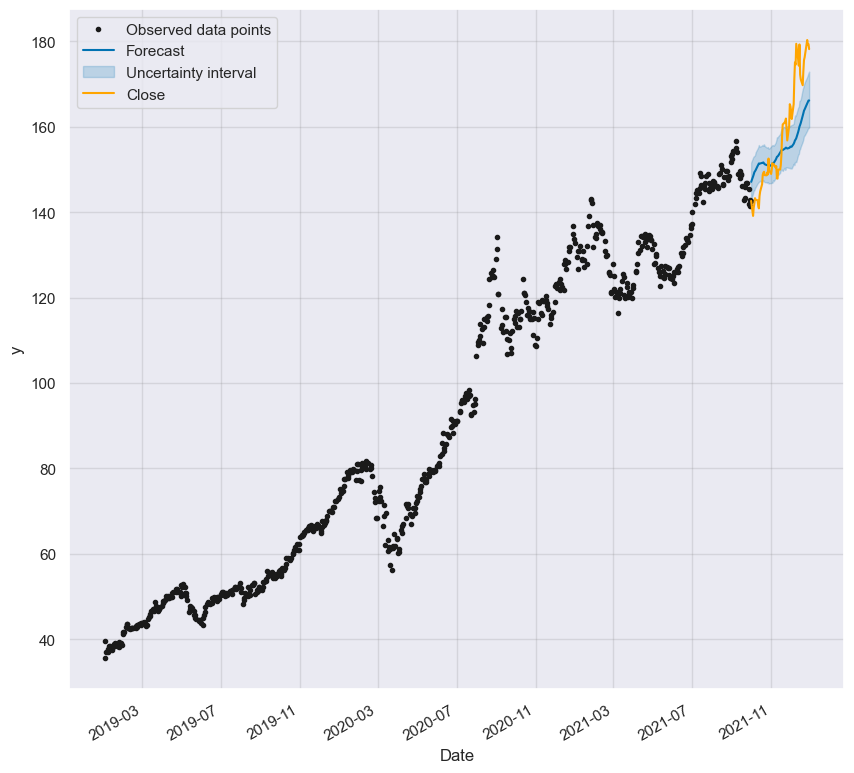

In [47]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig1 = model.plot(forecast, ax=ax1)
df[["Close"]].loc[train_end_date:].plot(ax=ax1, color="orange")
plt.legend()

In [48]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-10-01,151.058910,142.951002,151.604091,151.058910,151.058910,-3.950291,-3.950291,-3.950291,-2.344759,-2.344759,-2.344759,-1.605532,-1.605532,-1.605532,0.0,0.0,0.0,147.108620
1,2021-10-04,151.345587,144.421667,152.793188,151.345587,151.345587,-2.979305,-2.979305,-2.979305,-2.286624,-2.286624,-2.286624,-0.692681,-0.692681,-0.692681,0.0,0.0,0.0,148.366283
2,2021-10-05,151.441146,145.084010,153.073941,151.441146,151.441146,-2.599713,-2.599713,-2.599713,-2.218994,-2.218994,-2.218994,-0.380719,-0.380719,-0.380719,0.0,0.0,0.0,148.841433
3,2021-10-06,151.536705,145.112031,153.162099,151.536705,151.536705,-2.166635,-2.166635,-2.166635,-2.088997,-2.088997,-2.088997,-0.077637,-0.077637,-0.077637,0.0,0.0,0.0,149.370071
4,2021-10-07,151.632264,145.648249,153.346119,151.632264,151.632264,-2.030886,-2.030886,-2.030886,-2.240438,-2.240438,-2.240438,0.209552,0.209552,0.209552,0.0,0.0,0.0,149.601379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2021-12-23,158.990310,157.965905,170.341980,154.465431,163.564362,5.094009,5.094009,5.094009,-2.240438,-2.240438,-2.240438,7.334447,7.334447,7.334447,0.0,0.0,0.0,164.084319
59,2021-12-27,159.372546,159.145845,171.705504,154.739954,164.092772,6.110753,6.110753,6.110753,-2.286624,-2.286624,-2.286624,8.397377,8.397377,8.397377,0.0,0.0,0.0,165.483298
60,2021-12-28,159.468105,159.537970,172.142187,154.661814,164.278814,6.341635,6.341635,6.341635,-2.218994,-2.218994,-2.218994,8.560629,8.560629,8.560629,0.0,0.0,0.0,165.809740
61,2021-12-29,159.563664,159.675974,172.614857,154.603302,164.474350,6.593474,6.593474,6.593474,-2.088997,-2.088997,-2.088997,8.682471,8.682471,8.682471,0.0,0.0,0.0,166.157137


# Animation (working but not satisfying)

In [71]:
y = df["Close"].loc[train_end_date:]
future_x = forecast["ds"]

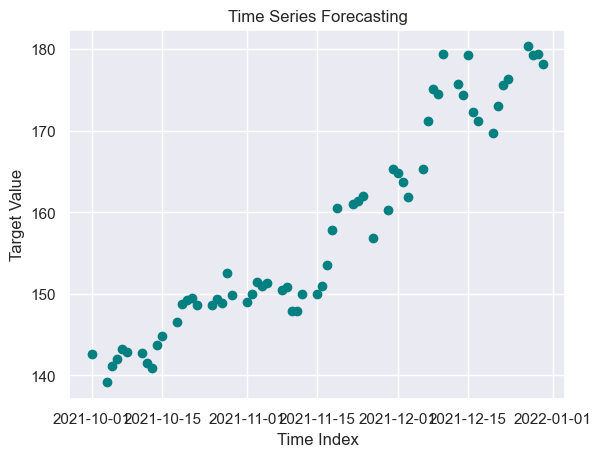

In [74]:
fig, ax = plt.subplots()
ax.set_title("Time Series Forecasting")
ax.set_xlabel("Time Index")
ax.set_ylabel("Target Value")
ax.scatter(future_x, y, color="teal")

line, = ax.plot([], [], color='navy')

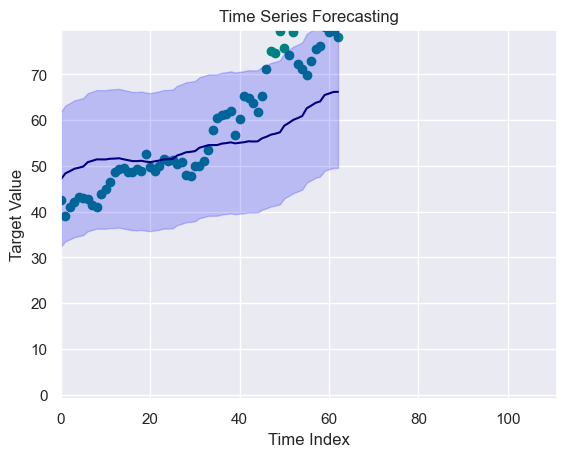

In [83]:

beginning_x = ""
beginning_y = df["Close"].loc[train_end_date:]

y = df["Close"].loc[train_end_date:] - 100
future_x = range(len(y))# forecast["ds"]
future_mean = forecast["yhat"] - 100
future_std = forecast["yhat"] * 0.1

# Création de la figure
fig, ax = plt.subplots()
ax.set_title("Time Series Forecasting")
ax.set_xlabel("Time Index")
ax.set_ylabel("Target Value")
ax.scatter(future_x, y, color="teal")

line, = ax.plot([], [], color='navy')
fill = None

# Limites initiales
# ax.set_xlim(0, 25)
# ax.set_ylim(-1, 1.5)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    global fill
    if fill:
        fill.remove()

    x_data = future_x[:i]
    y_mean = future_mean[:i]
    y_std = future_std[:i]

    line.set_data(x_data, y_mean)

    if len(x_data) > 0:
        fill = ax.fill_between(
            x_data,
            y_mean - y_std,
            y_mean + y_std,
            color='blue',
            alpha=0.2
        )
        target_xmax = 25 + i * 1.5
        target_ymax = max(1.5, np.max(y_mean + y_std) + 0.2)
    else:
        target_xmax = 25
        target_ymax = 1.5

    # --- Zoom fluide (effet easing) ---
    current_xlim = ax.get_xlim()
    current_ylim = ax.get_ylim()
    smooth_xmax = current_xlim[1] + 0.15 * (target_xmax - current_xlim[1])
    smooth_ymax = current_ylim[1] + 0.15 * (target_ymax - current_ylim[1])
    ax.set_xlim(0, smooth_xmax)
    ax.set_ylim(-1, smooth_ymax)
    # -----------------------------------

    return line, fill if fill else line

ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(future_x) + 1, interval=200, blit=False
)

ani.save("prophet.gif", writer='pillow', fps=15)
plt.show()


# Improve animation

In [91]:
len(y)

63

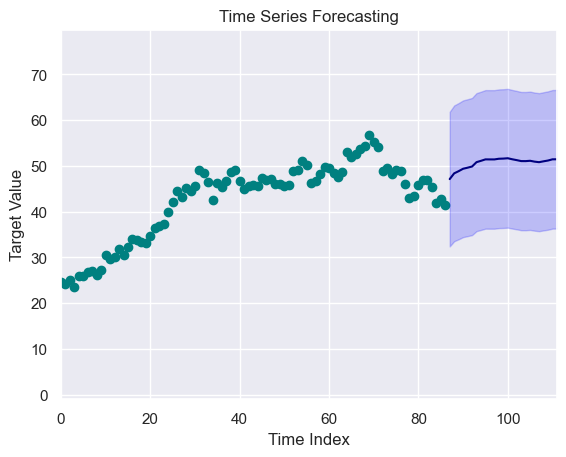

In [92]:
TEMP_OFFSET_TO_DELETE = 100
beginning_y = df["Close"][-150:-63] - TEMP_OFFSET_TO_DELETE
beginning_x = range(len(beginning_y))

y = df["Close"].loc[train_end_date:] - TEMP_OFFSET_TO_DELETE
future_x = range(len(beginning_y), len(beginning_y) + len(y))# forecast["ds"]
future_mean = forecast["yhat"] - TEMP_OFFSET_TO_DELETE
future_std = forecast["yhat"] * 0.1

# Création de la figure
fig, ax = plt.subplots()
ax.set_title("Time Series Forecasting")
ax.set_xlabel("Time Index")
ax.set_ylabel("Target Value")
ax.scatter(beginning_x, beginning_y, color="teal")

line, = ax.plot([], [], color='navy')
fill = None

# Limites initiales
# ax.set_xlim(0, 25)
# ax.set_ylim(-1, 1.5)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    global fill
    if fill:
        fill.remove()

    x_data = future_x[:i]
    y_mean = future_mean[:i]
    y_std = future_std[:i]

    line.set_data(x_data, y_mean)

    if len(x_data) > 0:
        fill = ax.fill_between(
            x_data,
            y_mean - y_std,
            y_mean + y_std,
            color='blue',
            alpha=0.2
        )
        target_xmax = 25 + i * 1.5
        target_ymax = max(1.5, np.max(y_mean + y_std) + 0.2)
    else:
        target_xmax = 25
        target_ymax = 1.5

    # --- Zoom fluide (effet easing) ---
    current_xlim = ax.get_xlim()
    current_ylim = ax.get_ylim()
    smooth_xmax = current_xlim[1] + 0.15 * (target_xmax - current_xlim[1])
    smooth_ymax = current_ylim[1] + 0.15 * (target_ymax - current_ylim[1])
    ax.set_xlim(0, smooth_xmax)
    ax.set_ylim(-1, smooth_ymax)
    # -----------------------------------

    return line, fill if fill else line

ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(future_x) + 1, interval=200, blit=False
)

ani.save("prophet2.gif", writer='pillow', fps=15)
plt.show()
